#  Fashion MNIST 分类任务

在本项目中，我们将使用 **Fashion MNIST** 数据集进行图像分类。Fashion MNIST 是一个包含 70,000 张 28x28 像素的灰度图像，表示 10 类服装物品。我们的任务是通过机器学习模型对这些图像进行分类。

## 数据集概览

- 数据集包含 10 个类别：T 恤/上衣、裤子、裙子、外套、凉鞋、衬衫、运动鞋、包包、靴子和运动鞋；
- 每个图像的尺寸为 28x28，灰度图像；
- 数据集分为训练集（60,000 图像）和测试集（10,000 图像）。
- 具体来说，数字标签的对应关系如下：
- 0 → 'T-shirt/top'
- 1 → 'Trouser'
- 2 → 'Pullover'
- 3 → 'Dress'
- 4 → 'Coat'
- 5 → 'Sandal'
- 6 → 'Shirt'
- 7 → 'Sneaker'
- 8 → 'Bag'
- 9 → 'Ankle boot'
- **后面为了，统一使用数字作为标签输出**

本项目的目标是使用 **MLP（多层感知机）** 和 **SVM（支持向量机）** 两种常见的机器学习模型来对数据进行分类，并对比它们的性能。

## 项目结构

1. **数据加载与预处理**：我们首先加载数据，并进行标准化处理，以便适应模型；
2. **MLP 模型训练与评估**：使用多层感知机训练并评估分类准确率；
3. **SVM 模型训练与评估**：使用支持向量机训练并评估分类准确率；
4. **模型对比**：最后，我们将比较两种模型在测试集上的表现，并展示图像分类效果。

---


##  任务目标

本项目的主要目标是通过使用两种不同的机器学习模型（MLP 和 SVM）对 Fashion MNIST 数据集进行图像分类，并进行如下分析：

1. **模型评估**：评估每个模型在测试集上的准确率，比较两者的表现；
2. **性能分析**：展示并解释每个模型的分类报告，包括精确度、召回率和 F1 分数；
3. **可视化效果**：展示部分预测结果，帮助我们直观理解模型的分类效果；
4. **模型比较**：使用准确率对比图表展示两个模型的性能差异。

我们将逐步构建并训练每个模型，最后将它们进行对比，得出最适合该任务的分类方法。

---



##  公共函数和库导入说明（Markdown 单元）

本部分我们统一导入所需库并定义 `plot_predictions` 函数。
- 它能展示多个测试图像的真实标签与模型预测标签，帮助我们直观评估模型分类效果。
- 后续的 MLP 与 SVM 部分都会调用此函数避免代码重复。


In [1]:
# 导入所需的库
import matplotlib.pyplot as plt
import os
import time 
import random
import logging
import json
import joblib
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from joblib import Parallel, delayed
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import font_manager
from joblib import Parallel, delayed
from tensorflow.keras.optimizers.schedules import ExponentialDecay
# 设置中文显示字体
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
print("导入成功")

导入成功


In [2]:
# 公共函数：展示预测结果
def plot_predictions(images, true_labels, pred_labels, images_per_row=5):
    num_images = len(images)
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2))
    axes = axes.flatten()
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"真:{true_labels[i]}\n预测:{pred_labels[i]}")
        ax.axis('off')
    for j in range(num_images, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

# 绘制训练曲线（精度与损失）
def plot_training_curve(epochs, train_acc, val_acc, train_loss, val_loss, model_name):
    plt.figure(figsize=(12, 5))
    # 绘制精度曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='训练集精度')
    plt.plot(epochs, val_acc, label='验证集精度')
    plt.title(f'{model_name} - 精度 - 程文展')
    plt.xlabel('Epochs')
    plt.ylabel('精度')
    plt.legend()
    # 绘制损失曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='训练集损失')
    plt.plot(epochs, val_loss, label='验证集损失')
    plt.title(f'{model_name} - 损失 - 程文展')
    plt.xlabel('Epochs')
    plt.ylabel('损失')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
# 准确率比较函数
def plot_accuracy_comparison(mlp_accuracy, svm_accuracy):
    plt.figure(figsize=(6, 4))
    plt.bar(['MLP', 'SVM'], [mlp_accuracy, svm_accuracy], color=['skyblue', 'salmon'])
    plt.title("MLP 与 SVM 模型准确率对比")
    plt.ylabel("准确率")
    plt.show()

# 显示多张图片的函数，按行显示
def plot_multiple_images(images, labels, start_index, num_images=5, images_per_row=5):
    # 计算需要多少行来展示这些图片
    num_rows = (num_images + images_per_row - 1) // images_per_row  # 向上取整
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2))    
    # 扁平化 axes 数组，方便迭代
    axes = axes.flatten()
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[start_index + i].reshape(28, 28), cmap='gray')  # 显示图像
        ax.set_title(f"标签: {labels[start_index + i]}")  # 设置标题为标签
        ax.axis('off')  # 不显示坐标轴   
    for j in range(num_images, len(axes)):
       axes[j].axis('off')   
    plt.tight_layout()
    plt.show()

print("定义函数完成")

定义函数完成


## 载入数据
根据文件的本地位置读入提前下载好的数据

In [3]:
# 加载数据
train_df = pd.read_csv(r"D:\jqxxdzy\fashion-mnist_train.csv")
test_df = pd.read_csv(r"D:\jqxxdzy\fashion-mnist_test.csv")

# 打印数据维度
print("训练集维度:", train_df.shape)
print("测试集维度:", test_df.shape)

训练集维度: (60000, 785)
测试集维度: (10000, 785)


## 提取特征和标签

从数据集中提取特征（图像数据）和标签（类别编号）。假设 `train_df` 和 `test_df` 是包含训练集和测试集数据的 Pandas DataFrame，其中第一列是标签，其余列是图像数据。


In [4]:
# 1. 提取训练集和测试集的特征和标签
x_train = train_df.iloc[:, 1:].values  # 特征（图像数据），去掉第一列标签
y_train = train_df.iloc[:, 0].values  # 标签（数字）

x_test = test_df.iloc[:, 1:].values  # 特征（图像数据），去掉第一列标签
y_test = test_df.iloc[:, 0].values  # 标签（数字）
print("数据已提取")

数据已提取


## 显示多张图像及其标签

为了直观地查看和理解 Fashion MNIST 数据集中的图像及其对应的标签，定义一个函数 `plot_multiple_ima
ges`。该函数允许用户指定要显示的图像数量、起始索引以及每行显示的图像数量。

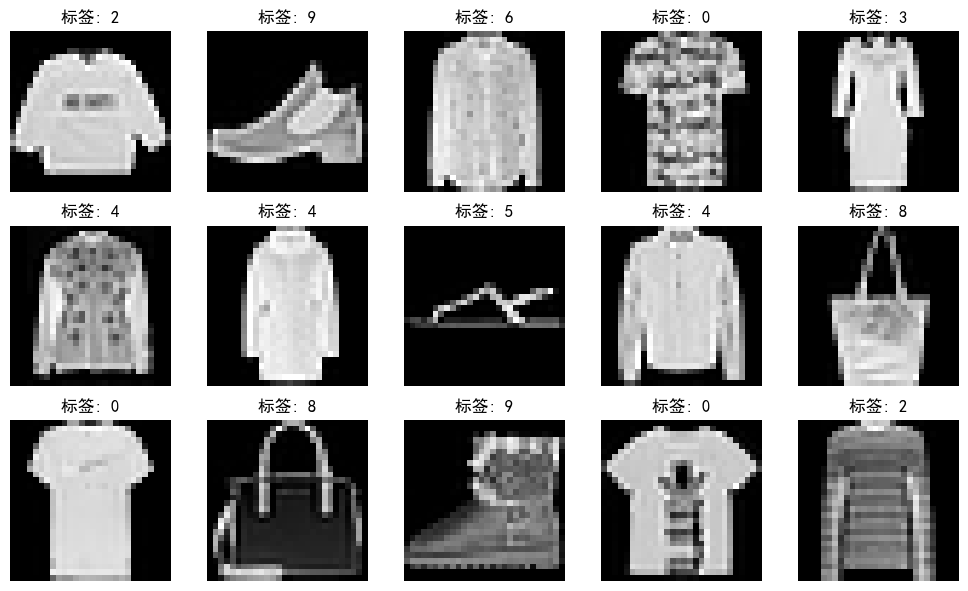

In [5]:
# 示例：展示15张图片，从第0张开始，每行展示5张
plot_multiple_images(x_train, y_train, start_index=0, num_images=15, images_per_row=5)

## 数据预处理

对提取的特征进行标准化处理，并将标签转换为独热编码格式，以便于后续的模型训练。


In [6]:
# 2. 数据预处理：标准化和标签转换
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 显式展平数据（虽然已经是二维数组，但明确说明更清晰）
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# 检查标签的原始形状
print("原始标签的形状:", y_train.shape)

# 将标签转换为独热编码
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 检查独热编码后的形状
print("独热编码后的训练标签形状:", y_train.shape)
print("独热编码后的测试标签形状:", y_test.shape)

原始标签的形状: (60000,)
独热编码后的训练标签形状: (60000, 10)
独热编码后的测试标签形状: (10000, 10)


## 显示训练集里面的数据分布
根据数据集里面的数据分布情况，可以判断使用这个数据集进行训练是否会有偏重不同的现象

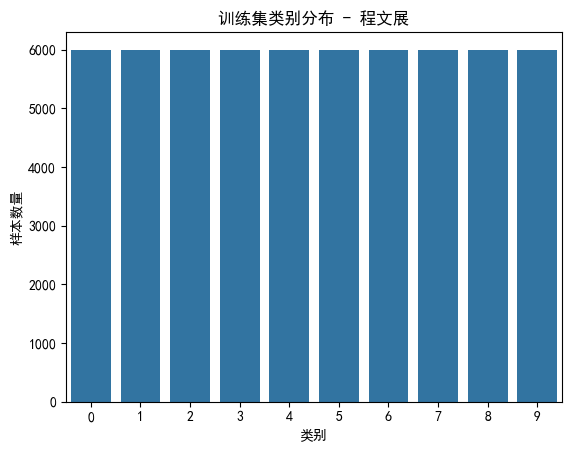

In [7]:
# 检查训练集类别分布
sns.countplot(x=np.argmax(y_train, axis=1))
plt.title("训练集类别分布 - 程文展")
plt.xlabel("类别")
plt.ylabel("样本数量")
plt.show()

##  MLP 方法说明（多层感知机）

本部分使用多层感知机（MLP）对 **Fashion MNIST** 数据进行分类。主要流程如下：

1. **数据预处理**：
   - 对输入图像进行 **归一化**，将像素值从 `[0, 255]` 转换到 `[0, 1]`，这样可以帮助加速模型的训练过程。
   - 使用 `to_categorical` 将标签转换为 **one-hot 编码格式**，这是处理多分类问题时常见的做法。

2. **构建 MLP 模型**：
   - **输入层**：输入形状为 784（28x28 像素的图像展平后的一维向量）。
   - **隐藏层**：
     - 第一层是 **全连接层**，包含 128 个神经元，使用 **ReLU 激活函数**，并应用 **L2 正则化**（`l2(0.001)`）来避免过拟合。
     - 第二层是 **全连接层**，包含 64 个神经元，同样使用 **ReLU 激活函数**，并应用 **L2 正则化**。
     - 在每个隐藏层后加入 **Dropout** 层（丢弃率为 20%），进一步减少过拟合。
   - **输出层**：包含 10 个神经元，使用 **Softmax 激活函数**，用于多分类输出。

3. **模型训练**：
   - **优化器**：使用 **Adam** 优化器进行训练，这是深度学习中常用的优化方法。
   - **损失函数**：使用 **categorical_crossentropy** 作为损失函数，因为这是多分类问题中常用的损失函数。
   - 训练时引入 **早停（EarlyStopping）**，如果验证集上的损失在连续若干轮内没有改善，则提前停止训练，防止过拟合。
   
4. **评估与可视化**：
   - 输出模型在测试集上的准确率，以评估模型的性能。
   - 使用 **分类报告** 展示 **精确度**、**召回率** 和 **F1 分数**，这些是多分类任务中常用的评估指标。
   - **混淆矩阵**：用来展示每个类别的预测结果，帮助理解模型在各类标签上的表现。
   - 随机选取图像，展示模型对图像的预测结果，直观展示模型的预测效果。

5. **模型正则化**：
   - 为了避免过拟合，在模型中加入 **L2 正则化** 和 **Dropout** 层，确保模型具有更好的泛化能力。

---

通过这个 MLP 模型，将能够有效地对 Fashion MNIST 数据集进行分类，并且通过正则化和早停等方法优化模型，防止过拟合，从而提高模型的测试集表现。


## 数据增强

对训练数据应用噪声增强，这是一种常用的数据增强技术，可以帮助模型提高泛化能力，减少过拟合的风险。


In [43]:
# 添加噪声增强
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)  # 确保像素值仍在 [0, 1] 范围内
print("数据噪声增强成功")

数据噪声增强成功


## 构建多层感知机 (MLP) 模型

构建一个多层感知机 (MLP) 模型，用于处理 Fashion MNIST 数据集。该模型包含输入层、多个隐藏层以及输出层。


In [44]:
# 构建模型
model = Sequential([
    Input(shape=(784,)),  # 使用 Input 层定义输入形状
    Dense(128, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),  # 增加 Dropout 层，丢弃率为 0.4  
    Dense(64, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),  # 增加 Dropout 层，丢弃率为 0.4
    Dense(10, activation='softmax')  # 输出层
])
print("MLP模型构建成功")

MLP模型构建成功


## 编译模型并设置回调函数

编译模型优化器并设置两个回调函数：`EarlyStopping` 和 `ReduceLROnPlateau`，以优化训练过程。


In [45]:
# 重新编译模型
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print("模型编译成功")

模型编译成功


In [46]:
# 设置 EarlyStopping 和微调 ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, min_lr=0.0001)
print("回调函数设置成功")

回调函数设置成功


In [47]:
# 训练模型
history = model.fit(x_train_noisy, y_train, epochs=100, batch_size=64, validation_split=0.15, 
                    callbacks=[early_stopping, reduce_lr])
print("模型训练成功")

Epoch 1/100
797/797 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6634 - loss: 1.9448 - val_accuracy: 0.8107 - val_loss: 0.7719 - learning_rate: 0.0010
Epoch 2/100
797/797 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7951 - loss: 0.7892 - val_accuracy: 0.7763 - val_loss: 0.7429 - learning_rate: 0.0010
Epoch 3/100
797/797 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8017 - loss: 0.7205 - val_accuracy: 0.7917 - val_loss: 0.6958 - learning_rate: 0.0010
Epoch 4/100
797/797 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7981 - loss: 0.7183 - val_accuracy: 0.8029 - val_loss: 0.6806 - learning_rate: 0.0010
Epoch 5/100
797/797 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8038 - loss: 0.7087 - val_accuracy: 0.8052 - val_loss: 0.6819 - learning_rate: 0.0010
Epoch 6/100
797/797 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8083 - loss: 0.6903 - val_accuracy: 0.8103 - val_loss: 0.6720 - learning_rate: 0.0010
Epoch 7/100
797/797 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8043 - los

## 保存模型
在训练完模型后，保存模型是一个重要的步骤，以便后续可以重新加载模型进行预测或进一步分析。TensorFlow 提供了多种保存模型的方式，包括保存为 `.keras` 或 `.h5` 格式。这些格式保存了模型的结构和权重，使得模型可以被轻松地加载和使用。


In [48]:
# 保存模型（添加正确的文件扩展名）
model.save('my_model.keras')  # 或者使用 .h5 扩展名: model.save('my_model.h5')

# 保存性能参数
performance_metrics = {
    "accuracy": history.history['accuracy'][-1],  # 取训练最后一个epoch的准确率
    "val_accuracy": history.history['val_accuracy'][-1],  # 取验证集最后一个epoch的准确率
    "loss": history.history['loss'][-1],  # 训练集最后一个epoch的损失
    "val_loss": history.history['val_loss'][-1]  # 验证集最后一个epoch的损失
}
with open('metrics.json', 'w') as f:
    json.dump(performance_metrics, f)

print("模型和性能参数保存成功")

模型和性能参数保存成功


In [49]:
# 加载保存的模型
model = tf.keras.models.load_model('my_model.keras')  # 或者 'my_model.h5'

# 加载保存的性能参数
with open('metrics.json', 'r') as f:
    performance_metrics = json.load(f)

# 输出性能参数
print("加载的性能参数:", performance_metrics)

加载的性能参数: {'accuracy': 0.8859999775886536, 'val_accuracy': 0.8702222108840942, 'loss': 0.37547311186790466, 'val_loss': 0.4271942675113678}


### 评估模型在测试集上的准确率

评估构建的多层感知机 (MLP) 模型在测试集上的准确率。准确率是衡量模型预测性能的常用指标，表示模型正确预测的样本数占总样本数的比例。

In [50]:
# 输出模型在测试集上的准确率
y_pred_mlp = model.predict(x_test)
y_pred_mlp_classes = np.argmax(y_pred_mlp, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
accuracy_mlp = accuracy_score(y_true_classes, y_pred_mlp_classes)
print("MLP 测试集准确率:", accuracy_mlp)
# 输出分类报告
report = classification_report(y_true_classes, y_pred_mlp_classes)
print("分类报告:")
print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MLP 测试集准确率: 0.8803
分类报告:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1000
           1       0.99      0.98      0.98      1000
           2       0.87      0.73      0.79      1000
           3       0.89      0.91      0.90      1000
           4       0.75      0.91      0.82      1000
           5       0.95      0.94      0.95      1000
           6       0.76      0.63      0.69      1000
           7       0.91      0.94      0.93      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### 可视化混淆矩阵

混淆矩阵是评估分类模型性能的有用工具，它显示了每个类别的预测结果与真实标签之间的关系。通过绘制多层感知机 (MLP) 模型的混淆矩阵，以直观地展示模型的分类效果。

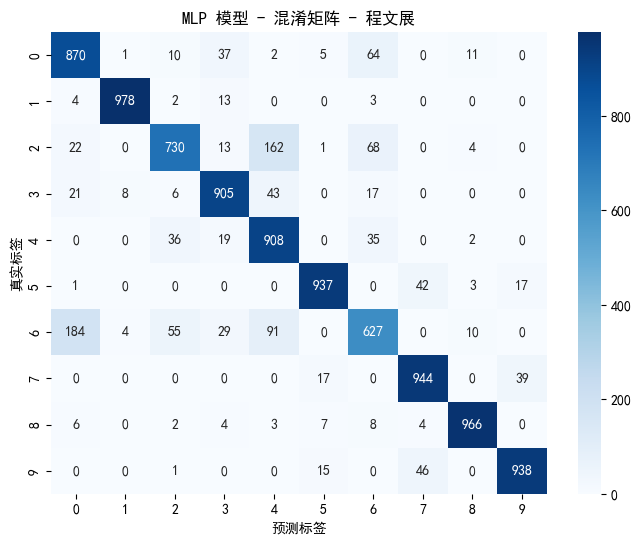

In [51]:
# 可视化混淆矩阵
conf_mat = confusion_matrix(y_true_classes, y_pred_mlp_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("MLP 模型 - 混淆矩阵 - 程文展")
plt.xlabel("预测标签")
plt.ylabel("真实标签")
plt.show()

### 随机选取部分结果展示

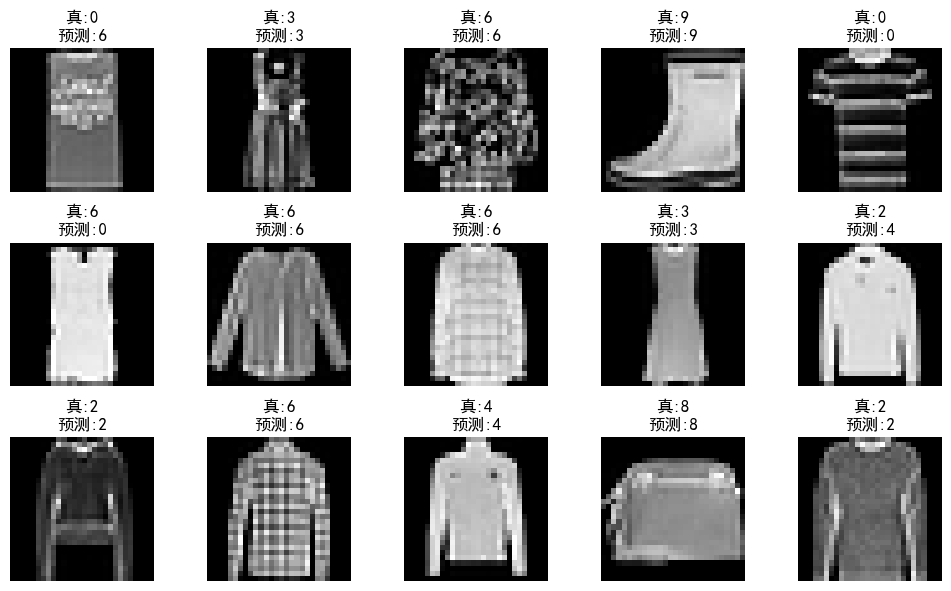

In [17]:
# 随机选择部分样本进行可视化预测结果
indices = random.sample(range(len(x_test)), 15)
plot_predictions(x_test[indices], y_true_classes[indices], y_pred_mlp_classes[indices])

### 可视化模型的准确率和损失率变化过程

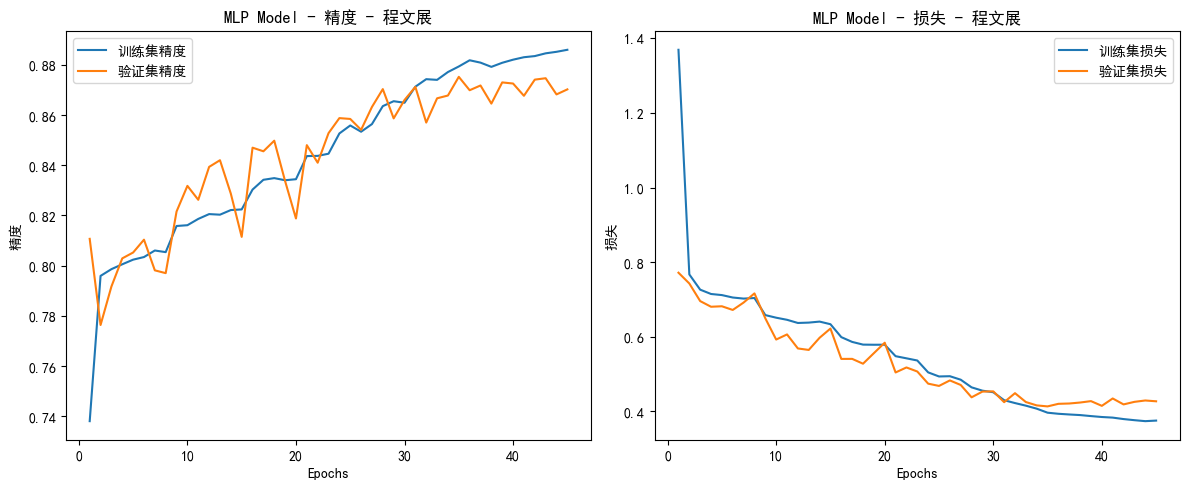

In [52]:
plot_training_curve(range(1, len(history.history['accuracy']) + 1), 
                    history.history['accuracy'], history.history['val_accuracy'],
                    history.history['loss'], history.history['val_loss'], "MLP Model")

##  SVM 方法说明（支持向量机）

本部分使用支持向量机（SVM）对 Fashion MNIST 数据进行分类。主要流程如下：

- 使用 `rbf` 核函数，参数设置为 `gamma='scale'`，`C=10`；
- 使用训练数据拟合模型，并对完整测试集进行预测；
- 输出模型在测试集上的准确率；
- 展示分类报告，包括精确度、召回率和 F1 分数；
- 随机选取图像展示 SVM 的分类效果。


 重新还原因为MLP处理过的数据集

In [27]:
# 将独热编码的 y_train 和 y_test 转换为原始的类别标签
y_train_classes = np.argmax(y_train, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print("转换成功")
x_train_small, _, y_train_small, _ = train_test_split(
    x_train, y_train, train_size=30000, stratify=y_train_classes, random_state=42
)
# 2. 获取对应的类别标签
y_train_small_classes = np.argmax(y_train_small, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


转换成功


### 数据降维处理

使用主成分分析（PCA）对 Fashion MNIST 数据集进行降维处理，以减少特征维度并简化模型训练过程。

In [28]:
# 标准化（均值=0，方差=1）
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_small)
x_test_scaled = scaler.transform(x_test)

# 对数据进行降维，减少特征维度
pca = PCA(n_components=100)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)
print(f"PCA降维后维度：{x_train_pca.shape[1]}") 

PCA降维后维度：100


### 超参数组合定义
在训练 SVM 模型之前，我们需要定义一组超参数组合，以便进行模型的训练和性能评估。这些超参数组合包括不同的核函数（`kernel`）、正则化参数（`C`）、核函数参数（`gamma`）以及多项式核的度数（`degree`）。


In [29]:
param_combinations = [
    {"kernel": "linear", "C": 1, "gamma":'scale'},
    {"kernel": "rbf", "C": 0.1, "gamma": "scale"},
    {"kernel": "rbf", "C": 1, "gamma": "scale"},
    {"kernel": "rbf", "C": 10, "gamma": "scale"},
    {"kernel": "poly", "C": 1, "gamma": "scale", "degree": 3},
    {"kernel": "poly", "C": 10, "gamma": "scale", "degree": 3}
]
performance_list = []

In [30]:
# 4. 创建保存目录
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

### 训练模型

- 确保保存目录存在
在开始训练模型之前，确保用于保存模型的目录存在。如果目录不存在，则创建它。这一步确保了后续保存模型文件时不会因目录不存在而出错。
- 清空性能列表
性能列表 performance_list 用于存储每个模型的训练结果和性能指标。在开始新的训练之前，清空该列表以避免重复记录。
- 定义训练函数
定义一个函数 train_svm，用于根据给定的超参数组合训练 SVM 模型。该函数接收超参数、训练数据、测试数据以及性能列表作为输入，训练模型并记录性能指标。
- 逐个训练模型
遍历超参数组合列表 param_combinations，调用 train_svm 函数逐个训练模型。每个模型的训练结果和性能指标将被记录到 performance_list 中。
- 保存所有模型
遍历 performance_list，使用 joblib.dump 将每个训练好的模型保存到指定的路径。这样，后续可以随时加载这些模型进行预测或进一步分析。

In [31]:
# 确保 models 文件夹存在
if not os.path.exists("models"):
    os.makedirs("models")
    
def train_svm(params, i, param_combinations, x_train_pca, y_train_classes, x_test_pca, y_test_classes, performance_list):
    kernel = params['kernel']
    C = params['C']
    gamma = params['gamma']
    degree = params.get('degree', None)

    print(f"[{i+1}/{len(param_combinations)}] 训练 SVM：kernel={kernel}, C={C}, gamma={gamma}, degree={degree}")

    start_time = time.time()

    # 设置 probability=True
    model = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree if degree else 3, probability=True)
    model.fit(x_train_pca, y_train_classes)  # 训练模型

    end_time = time.time()
    training_time = end_time - start_time

    # 预测和计算准确率
    y_pred = model.predict(x_test_pca)
    acc = accuracy_score(y_test_classes, y_pred)

    # 生成模型文件名
    name = f"{kernel}_C{C}_gamma{gamma}"
    if degree:
        name += f"_d{degree}"

    model_path = f"models/svm_{name}.pkl"

    # 保存训练结果到性能列表
    performance_list.append({
        "model_name": name,
        "kernel": kernel,
        "C": C,
        "gamma": gamma,
        "degree": degree,
        "accuracy": acc,
        "training_time_sec": round(training_time, 2),
        "model_path": model_path,
        "model": model  # 保存训练好的模型对象
    })

    print(f"训练完成，准确率为 {acc:.4f}，训练时间为 {training_time:.2f} 秒")

# 10. 逐个训练模型
for i, params in enumerate(param_combinations):
    train_svm(params, i, param_combinations, x_train_pca, y_train_small_classes, x_test_pca, y_test_classes, performance_list)

# 11. 保存所有模型
for result in performance_list: 
    model_path = result['model_path']
    joblib.dump(result['model'], model_path)  # 保存训练好的模型
    print(f"模型已保存至 {model_path}")

[1/6] 训练 SVM：kernel=linear, C=1, gamma=scale, degree=None
训练完成，准确率为 0.8534，训练时间为 865.77 秒
[2/6] 训练 SVM：kernel=rbf, C=0.1, gamma=scale, degree=None
训练完成，准确率为 0.8371，训练时间为 371.11 秒
[3/6] 训练 SVM：kernel=rbf, C=1, gamma=scale, degree=None
训练完成，准确率为 0.8805，训练时间为 228.76 秒
[4/6] 训练 SVM：kernel=rbf, C=10, gamma=scale, degree=None
训练完成，准确率为 0.8916，训练时间为 203.32 秒
[5/6] 训练 SVM：kernel=poly, C=1, gamma=scale, degree=3
训练完成，准确率为 0.8696，训练时间为 221.61 秒
[6/6] 训练 SVM：kernel=poly, C=10, gamma=scale, degree=3
训练完成，准确率为 0.8892，训练时间为 171.77 秒
模型已保存至 models/svm_linear_C1_gammascale.pkl
模型已保存至 models/svm_rbf_C0.1_gammascale.pkl
模型已保存至 models/svm_rbf_C1_gammascale.pkl
模型已保存至 models/svm_rbf_C10_gammascale.pkl
模型已保存至 models/svm_poly_C1_gammascale_d3.pkl
模型已保存至 models/svm_poly_C10_gammascale_d3.pkl


- 创建可序列化的性能指标列表
由于 performance_list 中包含了训练好的模型对象（SVC），而这些对象不能直接被序列化为 JSON 格式，因此需要创建一个新的列表 performance_list_serializable，移除每个字典中的 'model' 键。
- 保存性能指标到 JSON 文件
将可序列化的性能指标列表保存为 JSON 文件。JSON 格式便于后续的分析和可视化。

In [32]:
# 确保 results 文件夹存在
if not os.path.exists("results"):
    os.makedirs("results")

# 创建一个只包含 JSON 可序列化数据的列表
performance_list_serializable = []
for result in performance_list:
    # 创建一个新字典，移除 'model' 键
    result_serializable = {key: value for key, value in result.items() if key != 'model'}
    performance_list_serializable.append(result_serializable)

# 保存所有性能指标
with open('results/svm_all_metrics.json', 'w') as f:
    json.dump(performance_list_serializable, f, indent=2)

print("性能指标已保存到 results/svm_all_metrics.json")

性能指标已保存到 results/svm_all_metrics.json


### SVM 模型性能对比图（准确率 + 训练时间）

本图展示了在 Fashion MNIST 数据集上，不同超参数组合下的支持向量机（SVM）模型表现。

- **蓝色柱状图** 表示各个模型的分类准确率；
- **红色折线图** 表示模型训练所需时间（秒）；
- 模型名称位于 X 轴（通常是根据超参数组合自动命名的）；
- 左侧 Y 轴为准确率（0.7 - 1.0），右侧 Y 轴为训练时间（秒）；

通过该图，我们可以快速观察并比较：
- 哪些模型具有较高准确率；
- 哪些模型训练时间较短；
- 在准确率和训练时间之间找到平衡的最佳模型。

该图为 SVM 参数调优与模型选择提供了直观依据。


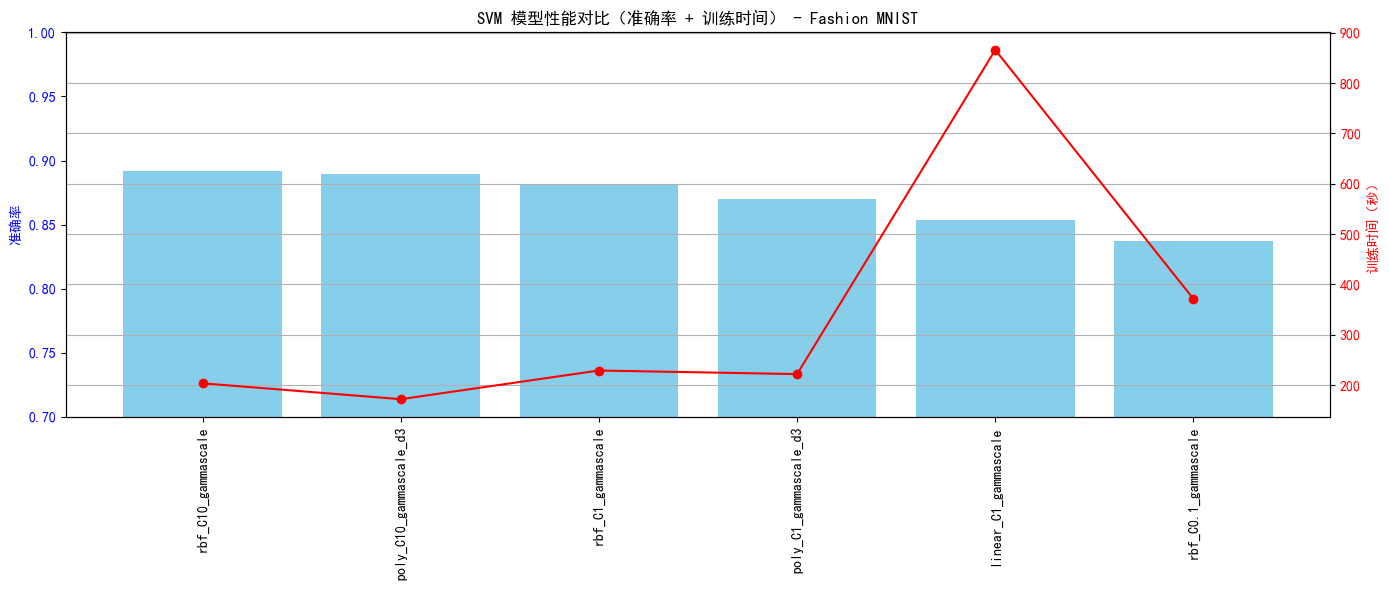

In [33]:
# 创建 DataFrame 并按准确率排序
df = pd.DataFrame(performance_list).sort_values(by='accuracy', ascending=False)

fig, ax1 = plt.subplots(figsize=(14, 6))

x = range(len(df))  # X轴位置索引

# 左轴：准确率柱状图
bar = ax1.bar(x, df['accuracy'], color='skyblue', label='准确率')
ax1.set_ylabel('准确率', color='blue')
ax1.set_ylim(0.7, 1.0)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(x)  # 设置刻度位置
ax1.set_xticklabels(df['model_name'], rotation=90)  # 设置刻度标签
ax1.set_title('SVM 模型性能对比（准确率 + 训练时间） - Fashion MNIST')

# 右轴：训练时间折线图
ax2 = ax1.twinx()
line = ax2.plot(x, df['training_time_sec'], color='red', marker='o', label='训练时间（秒）')
ax2.set_ylabel('训练时间（秒）', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 显示图例
fig.tight_layout()
plt.grid(axis='y')
plt.show()

In [34]:
# 8. 输出最优模型信息
best_model = df.iloc[0]
print("\n最优模型参数:")
print(best_model)

# 可重新加载最优模型
best_model_loaded = joblib.load(f"models/svm_{best_model['model_name']}.pkl")


最优模型参数:
model_name                          rbf_C10_gammascale
kernel                                             rbf
C                                                 10.0
gamma                                            scale
degree                                             NaN
accuracy                                        0.8916
training_time_sec                               203.32
model_path           models/svm_rbf_C10_gammascale.pkl
model                      SVC(C=10, probability=True)
Name: 3, dtype: object


### 测试模型性能

In [35]:
# 使用最优模型进行预测
y_pred = best_model_loaded.predict(x_test_pca)
y_pred_proba = best_model_loaded.predict_proba(x_test_pca)[:, 1]  # 获取正类的概率
# 输出模型在测试集上的准确率
accuracy_svm = accuracy_score(y_test_classes, y_pred)
print("SVM 测试集准确率:", accuracy_svm)

SVM 测试集准确率: 0.8916


### 随机选择部分样本进行可视化预测结果

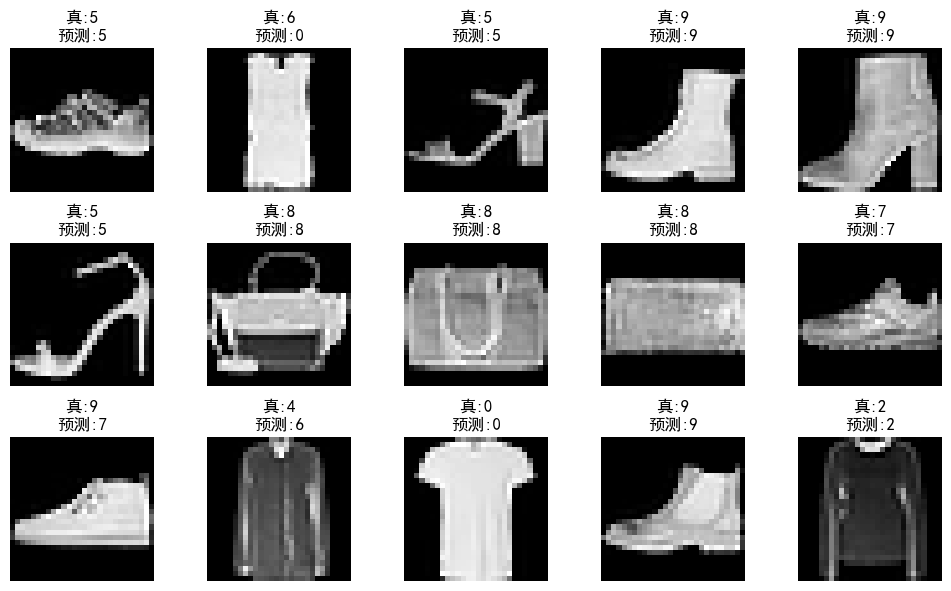

In [36]:
# 随机选择部分样本进行可视化预测结果
# 选择 15 个随机样本
indices = random.sample(range(len(x_test)), 15)
plot_predictions(x_test[indices], y_test_classes[indices], y_pred[indices])

### 输出分类报告

In [37]:
# 输出分类报告
print(classification_report(y_test_classes, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1000
           1       0.99      0.98      0.98      1000
           2       0.83      0.81      0.82      1000
           3       0.90      0.92      0.91      1000
           4       0.82      0.86      0.84      1000
           5       0.97      0.94      0.96      1000
           6       0.74      0.68      0.71      1000
           7       0.92      0.95      0.94      1000
           8       0.97      0.98      0.97      1000
           9       0.96      0.95      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### 输出混淆矩阵
通过混淆矩阵进行更加直观的可视化结果分析，具体的查看模型在各个大类里面的拟合度

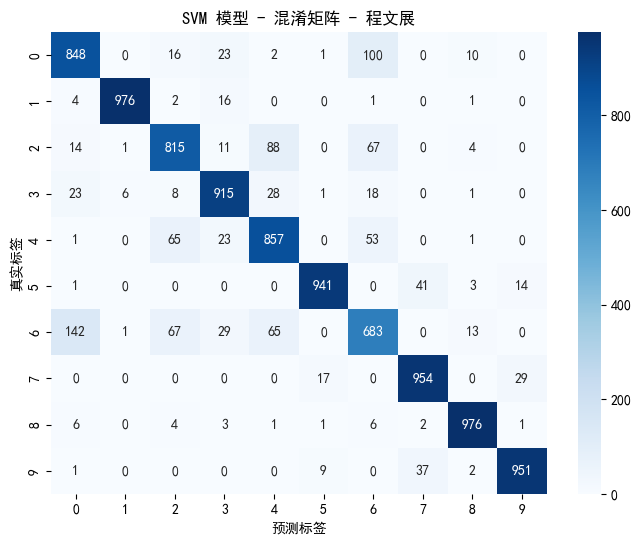

In [38]:
# 可视化混淆矩阵
conf_mat = confusion_matrix(y_test_classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("SVM 模型 - 混淆矩阵 - 程文展")
plt.xlabel("预测标签")
plt.ylabel("真实标签")
plt.show()

##  模型性能对比与总结

在本节中，我们将比较多层感知机（MLP）与支持向量机（SVM）在 Fashion MNIST 数据集上的表现。

- 两种模型均在相同的测试集上进行评估；
- MLP 使用全量训练数据进行训练，而 SVM 出于训练效率考虑，使用了训练加速；
- 对比模型在测试集上的准确率，并使用条形图直观展示；
- 最终目的是评估两种方法在图像分类任务中的优劣。

以下代码展示了准确率的可视化对比。


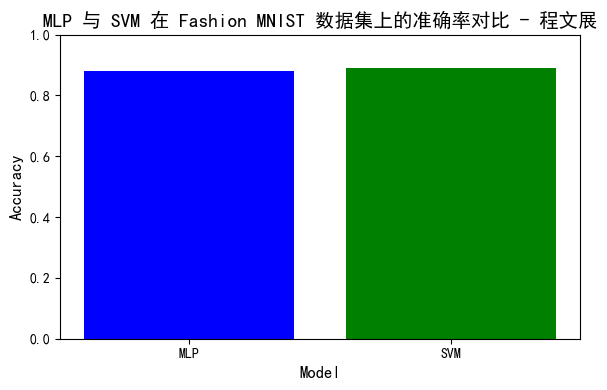

In [53]:
models = ['MLP', 'SVM']
# 准确率
accuracies = [accuracy_mlp, accuracy_svm]

# 绘制条形图，比较两个模型的准确率
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(models, accuracies, color=['blue', 'green'])

# 设置标题和标签
ax.set_title('MLP 与 SVM 在 Fashion MNIST 数据集上的准确率对比 - 程文展', fontsize=14)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_ylim(0, 1)

# 显示图形
plt.tight_layout()
plt.show()